[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/examples/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

In [1]:
from open_atmos_jupyter_utils import show_plot

TOC:
- run a basic constant-coefficient advection-diffusion simulation with Trixi.jl
- run analogous simulation with PyMPDATA
- compare output

## common settings

In [2]:
SETUP = {
    "nx": 32,
    "ny": 32,
    "Cx": 0.5,
    "Cy": 0.25,
    "dt": 0.025,
    "tmax": 1.0
}

import json
with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

## Trixi.jl

In [3]:
%%writefile trixi.jl
import Pkg
Pkg.add(["JSON", "Trixi", "OrdinaryDiffEq"])
using JSON
using Trixi
using OrdinaryDiffEq


setup = JSON.parsefile("setup.json")
advection_velocity = (setup["Cx"], setup["Cy"])
equations = LinearScalarAdvectionEquation2D(advection_velocity)

solver = DGSEM(polydeg = 3)

cells_per_dimension = (setup["nx"], setup["ny"])
coordinates_min = (-1.0, -1.0)
coordinates_max = ( 1.0,  1.0)

mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max)
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_convergence_test, solver)

tspan = (0.0, setup["tmax"])
ode = semidiscretize(semi, tspan);

summary_callback = SummaryCallback()
save_solution = SaveSolutionCallback(interval=100)

stepsize_callback = StepsizeCallback(cfl = 1.6)

callbacks = CallbackSet(summary_callback, save_solution, stepsize_callback)

time_int_tol = 1e-6
sol = solve(ode, CarpenterKennedy2N54();
            abstol = time_int_tol,
            reltol = time_int_tol,
            dt = setup["dt"],
            ode_default_options()..., callback = callbacks);

summary_callback()

Overwriting trixi.jl


In [4]:
%%bash
julia trixi.jl 2>&1

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`

████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝
┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… StructuredMesh{2, Float64}                                       │
│ equations: …………………………………………………… LinearScalarAdvectionEquation2D                                  │
│ initial condition: ……………………………… initial_conditi

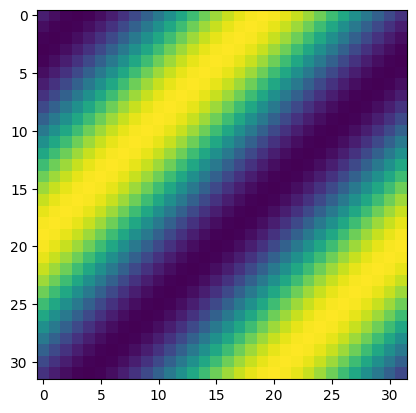

In [6]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

with h5py.File('out/solution_000031.h5', 'r') as f:
    # average every 16 points to reduce the number of points
    temp = np.array([np.mean(x) for x in f['variables_1'][:].reshape(-1, 16)])
    plt.imshow(temp[:].reshape(SETUP['ny'], SETUP['nx']).transpose())
    plt.show()

## PyMPDATA

In [7]:
import os
import numpy as np
import sympy as sp
from IPython.display import display
from ipywidgets import FloatProgress
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

In [8]:
steps_per_iter = 1
opt = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

In [9]:
x0 = -1.
y0 = -1.
boundary_conditions = (Periodic(), Periodic())

In [10]:
mu = 0.0
c = 1.
min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / SETUP['nx']
dy = (max_y - min_y) / SETUP['ny']
solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution = solution_symbolic.subs({"mu": mu})

In [11]:
def init_conditions(x, y):
    return solution_symbolic.subs({"t":0, "x": x, "y": y}).evalf()

In [12]:
z = np.array(
    [
        # [
            init_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

In [13]:
advectee = ScalarField(data=z, halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [14]:
field_x = np.full((SETUP['nx']+1, SETUP['ny']), SETUP['Cx'], dtype=opt.dtype)
field_y = np.full((SETUP['nx'], SETUP['ny']+1), SETUP['Cy'], dtype=opt.dtype)
advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [15]:
stepper = Stepper(options=opt, n_dims=2)

In [16]:
# create a solver
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

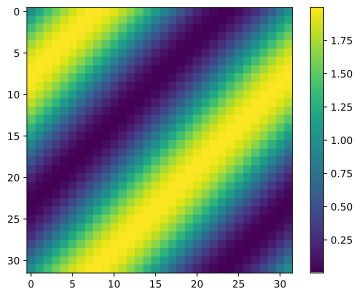

HTML(value="<a href='./tmp94l1uupw.pdf' target='_blank'>./tmp94l1uupw.pdf</a><br>")

In [17]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()
show_plot()

In [18]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
n_steps = 10
n_range = int(SETUP['tmax'] / SETUP['dt']) // n_steps
for i in range(n_range):
    solver.advance(n_steps=n_steps, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / n_range

FloatProgress(value=0.0, max=1.0)

Results comparison

In [19]:
trixi_result = temp[:].reshape(SETUP['ny'], SETUP['nx']).transpose()

# Calculate rmse between Trixi and PyMPDATA output
rmse = np.sqrt(np.mean((states_history[-1] - trixi_result) ** 2))
print(f"RMSE: {rmse:.4f}")

# Calculate min-max difference between Trixi and PyMPDATA output
min_max_diff = np.max(np.abs(states_history[-1] - trixi_result))
print(f"Min-max difference: {min_max_diff:.4f}")

RMSE: 1.0485
Min-max difference: 1.4822


In [20]:
with h5py.File('out/solution_000000.h5', 'r') as f:
    trixi_init = np.array([np.mean(x) for x in f['variables_1'][:].reshape(-1, 16)])
    trixi_init = trixi_init[:].reshape(SETUP['ny'], SETUP['nx']).transpose()

In [21]:
assert np.abs(np.sum(states_history[-1]) - np.sum(states_history[0])) < 1e-6
assert np.abs(np.sum(trixi_result) - np.sum(trixi_init)) < 1e-6

In [22]:
np.sum(states_history[-1]), np.sum(states_history[0])

(1024.0, 1024.0)

In [23]:
mu = 0.0
min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / SETUP['nx']
dy = (max_y - min_y) / SETUP['ny']
nt = int(SETUP['tmax'] / SETUP['dt'])
solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution = solution_symbolic.subs({"mu": mu})

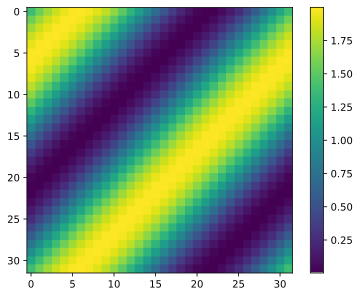

HTML(value="<a href='./tmpg5rok8x5.pdf' target='_blank'>./tmpg5rok8x5.pdf</a><br>")

In [24]:
solution_symbolic_final = sp.sympify("sin(pi*(x-cx*dx*nt + y-cy*dx*nt)) + 1", rational=True)
def final_conditions(x, y):
    return solution_symbolic_final.subs({"cx": SETUP['Cx'], "cy": SETUP['Cy'], "t":SETUP['tmax'], "dx": dx, "dy": dy, "nt": nt, "x": x, "y": y}).evalf()

z_final = np.array(
    [
        # [
            final_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

plt.imshow(z_final, cmap='viridis')
plt.colorbar()
show_plot()

In [25]:
# Calculate rmse between analytical solution, Trixi and PyMPDATA output
rmse = np.sqrt(np.mean((states_history[-1] - z_final) ** 2))
print(f"PyMPDATA - RMSE: {rmse:.4f}")

rmse = np.sqrt(np.mean((trixi_result - z_final) ** 2))
print(f"Trixi - RMSE: {rmse:.4f}")

PyMPDATA - RMSE: 0.0942
Trixi - RMSE: 1.0397


In [26]:
# Calculate min-max difference between analytical solution, Trixi and PyMPDATA output
min_max_diff = np.max(np.abs(states_history[-1] - z_final))
print(f"PyMPDATA - Min-max difference: {min_max_diff:.4f}")

min_max_diff = np.max(np.abs(trixi_result - z_final))
print(f"Trixi - Min-max difference: {min_max_diff:.4f}")

PyMPDATA - Min-max difference: 0.2813
Trixi - Min-max difference: 1.4856


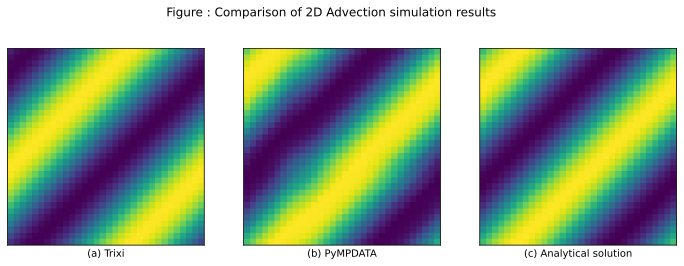

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

# Title
fig.suptitle("Figure : Comparison of 2D Advection simulation results")

# Plot Trixi output
axs[0].imshow(trixi_result, cmap='viridis')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel("(a) Trixi")

# Plot PyMPDATA output
axs[1].imshow(states_history[-1], cmap='viridis')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel("(b) PyMPDATA")

# Plot analytical solution
axs[2].imshow(z_final, cmap='viridis')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel("(c) Analytical solution")

plt.show()

Animation

In [24]:
# save each frame as a png to animation2 folder
os.makedirs("animation2", exist_ok=True)
for i, state in enumerate(states_history):
    # flip the image vertically
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.colorbar()
    plt.savefig(f"animation2/frame_{i:03d}.png")
    plt.close()

In [0]:
def get_advection_diffusion_gif(states):
    fig, ax = plt.subplots()
    ax.set_xlim(0, SETUP['nx'])
    ax.set_ylim(0, SETUP['ny'])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Advection-Diffusion Equation")
    im = ax.imshow(states[0], cmap='viridis')
    def update(i):
        im.set_array(states[i])
        return im,
    anim = FuncAnimation(fig, update, frames=len(states), blit=True)
    
    anim.save("advection_diffusion.gif", writer='imagemagick', fps=10)

In [0]:
get_advection_diffusion_gif(states_history)

Load VTK file

In [0]:
from vtk.util.numpy_support import vtk_to_numpy
import vtk
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [0]:
mesh = meshio.read("solution_000026.vtu")

In [0]:
# mesh.point_data["scalar"]

In [0]:
arr = np.array(mesh.point_data["scalar"])

In [0]:
# [x.data for x in  mesh.cells]

In [0]:
# mesh.cells[0].data.shape

In [0]:
# for block in [x for x in mesh.cells]:
#     print(np.array(block.data).shape)

In [0]:
arr = arr[::16]
plt.imshow(arr.reshape(16, 32, order="C").transpose())
plt.show()